In [62]:
import copy
import sys
from datetime import time

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
import PIL.Image as Image
import numpy as np
from typing_extensions import dataclass_transform
import time

In [63]:
from torchvision.datasets import ImageFolder

train_dataset = ImageFolder(
    root="./flower/flower_data/train",
    transform=transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
    ]),
)

In [64]:
data_dir="./flower/flower_data/"
train_dir = data_dir + "train"
valid_dir = data_dir + "valid"

data_transforms ={
    "train": transforms.Compose([
        transforms.RandomRotation(45),#随机旋转
        transforms.CenterCrop(224),#中心剪裁
        transforms.RandomHorizontalFlip(p=0.5),#随机水平翻转
        transforms.RandomVerticalFlip(p=0.5),#随机垂直翻转
        transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.1), #亮度、对比对、饱和度、色相
        transforms.RandomGrayscale(p=0.025),#概率转成灰度率
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    "valid": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),#中心剪裁
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

batch_size = 8
image_datasets = {
    x: datasets.ImageFolder(data_dir + x, data_transforms[x]) for x in ["train", "valid"]
}
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True) for x in ["train", "valid"]
}
datasizes = {
    x: len(image_datasets[x]) for x in ["train", "valid"]
}
class_names = image_datasets['train'].classes

In [65]:
# A mapping of category names to labels
cat_to_name = {"21": "fire lily", "3": "canterbury bells", "45": "bolero deep blue", "1": "pink primrose", "34": "mexican aster", "27": "prince of wales feathers", "7": "moon orchid", "16": "globe-flower", "25": "grape hyacinth", "26": "corn poppy", "79": "toad lily", "39": "siam tulip", "24": "red ginger", "67": "spring crocus", "35": "alpine sea holly", "32": "garden phlox", "10": "globe thistle", "6": "tiger lily", "93": "ball moss", "33": "love in the mist", "9": "monkshood", "102": "blackberry lily", "14": "spear thistle", "19": "balloon flower", "100": "blanket flower", "13": "king protea", "49": "oxeye daisy", "15": "yellow iris", "61": "cautleya spicata", "31": "carnation", "64": "silverbush", "68": "bearded iris", "63": "black-eyed susan", "69": "windflower", "62": "japanese anemone", "20": "giant white arum lily", "38": "great masterwort", "4": "sweet pea", "86": "tree mallow", "101": "trumpet creeper", "42": "daffodil", "22": "pincushion flower", "2": "hard-leaved pocket orchid", "54": "sunflower", "66": "osteospermum", "70": "tree poppy", "85": "desert-rose", "99": "bromelia", "87": "magnolia", "5": "english marigold", "92": "bee balm", "28": "stemless gentian", "97": "mallow", "57": "gaura", "40": "lenten rose", "47": "marigold", "59": "orange dahlia", "48": "buttercup", "55": "pelargonium", "36": "ruby-lipped cattleya", "91": "hippeastrum", "29": "artichoke", "71": "gazania", "90": "canna lily", "18": "peruvian lily", "98": "mexican petunia", "8": "bird of paradise", "30": "sweet william", "17": "purple coneflower", "52": "wild pansy", "84": "columbine", "12": "colt's foot", "11": "snapdragon", "96": "camellia", "23": "fritillary", "50": "common dandelion", "44": "poinsettia", "53": "primula", "72": "azalea", "65": "californian poppy", "80": "anthurium", "76": "morning glory", "37": "cape flower", "56": "bishop of llandaff", "60": "pink-yellow dahlia", "82": "clematis", "58": "geranium", "75": "thorn apple", "41": "barbeton daisy", "95": "bougainvillea", "43": "sword lily", "83": "hibiscus", "78": "lotus lotus", "88": "cyclamen", "94": "foxglove", "81": "frangipani", "74": "rose", "89": "watercress", "73": "water lily", "46": "wallflower", "77": "passion flower", "51": "petunia"}

In [66]:
def im_convert(tensor):
    device = torch.device("mps")
    image = tensor.to(device).clone().detach()
    image = image.cpu().numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    image = image.clip(0, 1)
    return image

tensor([  5,  14, 100,  76,  77,  25,  45,  29])


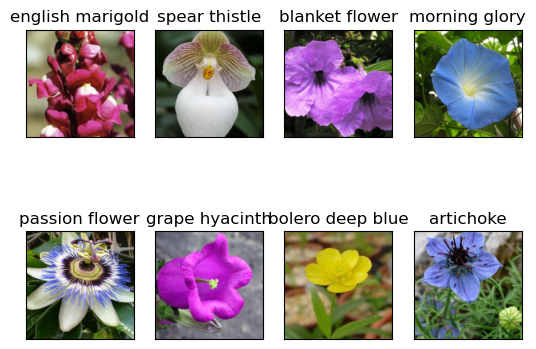

In [67]:
import matplotlib.pyplot as plt
fig = plt.figure()
columns = 4
rows = 2

dataiter = iter(dataloaders['valid'])
inputs, classes = next(dataiter)
print(classes)
for idx in range(columns * rows):
    ax = fig.add_subplot(rows, columns, idx+1, xticks=[], yticks=[])
    ax.set_title(cat_to_name[str(int(classes[idx]))])
    plt.imshow(im_convert(inputs[idx]))
plt.show()


In [68]:
feature_extract = True
train_on_mps = torch.mps.is_available()
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("mps is {}".format(train_on_mps))

mps is True


In [69]:
def set_parameter_requires_grad(model, feature_extract):
    if feature_extract:
        for param in model.parameters():
            param.requires_grad = False

In [70]:
model_ft = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V1)
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [71]:
def initialize_model(num_classes, feature_extract):
    input_size = 224
    model_ft = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V1)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Sequential(nn.Linear(num_ftrs, num_classes),
                                nn.LogSoftmax(dim=1))
    return model_ft, input_size


In [72]:
model_ft, input_size = initialize_model(102, feature_extract)

model_ft = model_ft.to(device)

filename = 'checkpoint.pth'

parameters = model_ft.parameters()
print("parameters to learn:")
if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad:
            params_to_update.append(param)
            print("\t", name)
else:
    for name, param in model_ft.named_parameters():
        if param.requires_grad:
            print("\t", name)

parameters to learn:
	 fc.0.weight
	 fc.0.bias


In [73]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [74]:
optimizer = torch.optim.Adam(params_to_update, lr=1e-2)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) ## 7个epoch后衰减到原来的1/10
criterion = torch.nn.NLLLoss()
print(optimizer.param_groups)

[{'params': [Parameter containing:
tensor([[-0.0012,  0.0184,  0.0099,  ..., -0.0117,  0.0105, -0.0077],
        [-0.0062,  0.0214, -0.0006,  ..., -0.0016, -0.0086,  0.0068],
        [ 0.0140, -0.0077,  0.0220,  ...,  0.0073, -0.0025,  0.0162],
        ...,
        [ 0.0158,  0.0041, -0.0107,  ..., -0.0204, -0.0003, -0.0212],
        [ 0.0050, -0.0003,  0.0020,  ..., -0.0216,  0.0189,  0.0105],
        [-0.0220,  0.0076, -0.0167,  ..., -0.0159, -0.0164, -0.0189]],
       device='mps:0', requires_grad=True), Parameter containing:
tensor([ 7.0803e-03, -4.5315e-03, -9.4648e-03,  7.9444e-03,  1.9390e-02,
        -8.5677e-04,  4.3687e-04,  4.3602e-04, -1.4837e-02, -1.0088e-02,
         2.8862e-03,  7.0201e-03, -2.5763e-03,  1.3781e-02,  5.1122e-03,
         6.2514e-03,  1.2882e-02,  2.1517e-02,  6.5087e-03, -8.3173e-03,
        -1.2753e-02,  8.2277e-03, -5.9888e-03,  4.2869e-03, -1.6142e-02,
         1.2632e-02, -1.5453e-02,  2.0631e-02,  1.7881e-02,  1.8225e-04,
        -2.0051e-02,  1.163

In [75]:
optimizer.param_groups[0]['lr']

0.01

In [76]:
def train_model(model, dataloaders, criterion, optimizer, num_epoch=25, filename='checkpoint.pth'):
    since = time.time()
    best_accuracy = 0
    model.to(device)

    val_acc_history = []
    train_acc_history = []
    train_losses = []
    val_losses = []
    LRs = [optimizer.param_groups[0]['lr']]

    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epoch):
        print('Epoch {}/{}'.format(epoch + 1, num_epoch))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item() * inputs.size(0) ## 均值乘以个数
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)

            time_elapsed = time.time() - since
            print("Time elapsed {}m {}s".format(time_elapsed // 60, time_elapsed % 60))
            print("{} Loss: {:.4f} | Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))

            if phase == 'valid' and epoch_acc > best_accuracy:
                best_accuracy = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                state = {
                    'state_dict': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'best_accuracy': best_accuracy,
                }
                torch.save(state, filename)

            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_losses.append(epoch_loss)

            if phase == 'valid':
                val_acc_history.append(epoch_acc)
                val_losses.append(epoch_loss)

        print("Optimizer learning rate: {}".format(optimizer.param_groups[0]['lr']))
        LRs.append(optimizer.param_groups[0]['lr'])
        scheduler.step()
        print()

    time_elapsed = time.time() - since
    print("Training complete in {}m {}s".format(time_elapsed // 60, time_elapsed % 60))

    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_losses, val_losses, LRs


In [77]:
model_ft, val_acc_history, train_losses, val_losses, LRs = train_model(model_ft, dataloaders, criterion, optimizer, num_epoch=12, filename='checkpoint.pth')

Epoch 1/12
----------
Time elapsed 1.0m 19.51439380645752s
train Loss: 10.0987 | Acc: 0.3170
Time elapsed 1.0m 28.03774380683899s
valid Loss: 15.4954 | Acc: 0.3130
Optimizer learning rate: 0.01

Epoch 2/12
----------
Time elapsed 2.0m 47.5400116443634s
train Loss: 8.2760 | Acc: 0.4901
Time elapsed 2.0m 55.90998196601868s
valid Loss: 10.7758 | Acc: 0.5000
Optimizer learning rate: 0.01

Epoch 3/12
----------
Time elapsed 4.0m 14.757327795028687s
train Loss: 7.9881 | Acc: 0.5514
Time elapsed 4.0m 23.200608015060425s
valid Loss: 11.3398 | Acc: 0.5196
Optimizer learning rate: 0.01

Epoch 4/12
----------
Time elapsed 5.0m 43.24748706817627s
train Loss: 7.7335 | Acc: 0.5923
Time elapsed 5.0m 51.879047870635986s
valid Loss: 16.2444 | Acc: 0.4474
Optimizer learning rate: 0.01

Epoch 5/12
----------
Time elapsed 7.0m 10.967256784439087s
train Loss: 7.6388 | Acc: 0.6230
Time elapsed 7.0m 19.351186990737915s
valid Loss: 10.9444 | Acc: 0.5880
Optimizer learning rate: 0.01

Epoch 6/12
----------
Tim

In [78]:
dict = torch.load(filename)
dict.keys()

dict_keys(['state_dict', 'optimizer', 'best_accuracy'])

## 在原来的基础上继续训练所有层

In [79]:
model_ft2, input_size = initialize_model(102, feature_extract)
for param in model_ft2.parameters():
    param.requires_grad = True

optimizer2 = torch.optim.Adam(model_ft2.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer2, step_size=7, gamma=0.1)
criterion = torch.nn.NLLLoss()

In [80]:
checkpoint = torch.load('checkpoint.pth')
best_acc = checkpoint['best_accuracy']
model_ft2.load_state_dict(checkpoint['state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer'])


<All keys matched successfully>

In [81]:
model_ft2, val_acc_history, train_losses, val_losses, LRs = train_model(model_ft2, dataloaders, criterion, optimizer2, num_epoch=12, filename='checkpoint2.pth')

Epoch 1/12
----------
Time elapsed 3.0m 30.019338130950928s
train Loss: 3.5751 | Acc: 0.7141
Time elapsed 3.0m 38.399982213974s
valid Loss: 2.6444 | Acc: 0.7433
Optimizer learning rate: 0.0001

Epoch 2/12
----------
Time elapsed 7.0m 10.805715322494507s
train Loss: 0.9705 | Acc: 0.8371
Time elapsed 7.0m 19.29666018486023s
valid Loss: 1.7964 | Acc: 0.7800
Optimizer learning rate: 0.0001

Epoch 3/12
----------
Time elapsed 10.0m 52.09373903274536s
train Loss: 0.5927 | Acc: 0.8674
Time elapsed 11.0m 0.42781901359558105s
valid Loss: 2.1830 | Acc: 0.7543
Optimizer learning rate: 0.0001

Epoch 4/12
----------
Time elapsed 14.0m 30.015644311904907s
train Loss: 0.4816 | Acc: 0.8846
Time elapsed 14.0m 38.34604811668396s
valid Loss: 2.3235 | Acc: 0.7579
Optimizer learning rate: 0.0001

Epoch 5/12
----------
Time elapsed 18.0m 7.378408193588257s
train Loss: 0.4919 | Acc: 0.8777
Time elapsed 18.0m 15.603231191635132s
valid Loss: 1.7372 | Acc: 0.7567
Optimizer learning rate: 0.0001

Epoch 6/12
----

In [84]:
cnt = 0
for name, param in model_ft2.named_parameters():
    print(name, param.size())
    cnt += 1
print(cnt)

conv1.weight torch.Size([64, 3, 7, 7])
bn1.weight torch.Size([64])
bn1.bias torch.Size([64])
layer1.0.conv1.weight torch.Size([64, 64, 1, 1])
layer1.0.bn1.weight torch.Size([64])
layer1.0.bn1.bias torch.Size([64])
layer1.0.conv2.weight torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight torch.Size([64])
layer1.0.bn2.bias torch.Size([64])
layer1.0.conv3.weight torch.Size([256, 64, 1, 1])
layer1.0.bn3.weight torch.Size([256])
layer1.0.bn3.bias torch.Size([256])
layer1.0.downsample.0.weight torch.Size([256, 64, 1, 1])
layer1.0.downsample.1.weight torch.Size([256])
layer1.0.downsample.1.bias torch.Size([256])
layer1.1.conv1.weight torch.Size([64, 256, 1, 1])
layer1.1.bn1.weight torch.Size([64])
layer1.1.bn1.bias torch.Size([64])
layer1.1.conv2.weight torch.Size([64, 64, 3, 3])
layer1.1.bn2.weight torch.Size([64])
layer1.1.bn2.bias torch.Size([64])
layer1.1.conv3.weight torch.Size([256, 64, 1, 1])
layer1.1.bn3.weight torch.Size([256])
layer1.1.bn3.bias torch.Size([256])
layer1.2.conv1.weight tor

In [85]:
optimizer3 = torch.optim.Adam(model_ft2.parameters(), lr=1e-4)
old_state = checkpoint['optimizer']
old_state

{'state': {0: {'step': tensor(9828.),
   'exp_avg': tensor([[ 1.5702e-03,  2.3280e-04,  7.6069e-04,  ...,  2.0428e-04,
             3.4845e-04,  1.4528e-04],
           [ 1.7141e-11,  2.3424e-11,  1.2040e-12,  ...,  6.9683e-12,
             3.7165e-12,  8.3691e-12],
           [-2.1310e-06, -1.5172e-06, -1.2661e-06,  ..., -6.1883e-07,
            -5.3999e-07, -1.3270e-06],
           ...,
           [ 4.7487e-03,  2.9899e-03,  4.1697e-03,  ...,  1.2228e-03,
             2.4663e-03,  8.1682e-04],
           [ 5.9098e-03,  5.1596e-03,  1.9457e-03,  ...,  1.9640e-03,
             3.3862e-03,  3.7478e-03],
           [ 1.9451e-05,  2.6757e-05,  5.9246e-05,  ...,  2.0938e-05,
             1.6197e-05,  3.2493e-05]], device='mps:0'),
   'exp_avg_sq': tensor([[1.8139e-04, 5.6465e-05, 2.3734e-04,  ..., 2.1170e-05, 3.8160e-05,
            7.2081e-05],
           [6.7961e-05, 4.8313e-05, 7.0906e-05,  ..., 1.7747e-05, 5.6122e-06,
            4.9334e-06],
           [3.9445e-05, 3.7305e-05, 1.1445e

完全正确，即使升级到 PyTorch ≥2.9，state key 变成 **参数对象 id**，在另一个应用重新创建模型时也会 **无法匹配**。原因如下：

---

### 1️⃣ 为什么 id key 也不行

* `optimizer.state_dict()['state']` 的 key 是 `id(param)`
* `id(param)` 是 **Python 对象在内存中的地址**
* 重新创建模型时，即使层名字和结构完全一样：

  * 每个 `nn.Parameter` 都是新对象
  * 对应的 id 与原来完全不同
* 所以 state key 仍然不匹配，旧 optimizer state **无法恢复**

---

### 2️⃣ 影响

* 断点训练无法完全恢复 Adam / RMSProp 的动量状态
* 重新初始化 optimizer 后训练可以继续，但动量从零开始，收敛可能慢一点

---

### 3️⃣ 解决思路

1. **只加载模型权重**，在新应用重新创建 optimizer

   * 适合迁移学习或推理，不依赖旧优化器状态

2. **跨应用恢复 optimizer 状态（复杂）**

   * 需要按 **参数名字** 或层名字手动匹配状态
   * 遍历 `optimizer.state`，把对应参数的状态复制到新模型的参数
   * 这种方法可行，但实现复杂，不常用

---

✅ 总结：

* **同一应用/同一模型对象** → id key 可以完全恢复 optimizer state
* **另一个应用重新创建模型** → id key 也无法匹配，state 必须重新初始化

---

我可以写一个 **按名字匹配参数状态的示例函数**，让你在不同应用也能尽量恢复 Adam/RMSProp state（不依赖 id）。

你希望我写吗？


对的，`optimizer.load_state_dict()` 的行为确实会 **完全覆盖当前 optimizer 的状态**，下面详细说明：

---

### 1️⃣ 覆盖内容

当你调用：

```python
optimizer.load_state_dict(checkpoint['optimizer'])
```

* **param_groups** → 会被 checkpoint 中的 param_groups 完全替换
* **state** → 也会被 checkpoint 中的 state 完全替换
* **原有的参数状态**（包括 step、动量、Adam 的 `exp_avg`、`exp_avg_sq` 等）全部被清掉

换句话说：

* **当前 optimizer 的任何自定义修改、学习率调整、已有 momentum 等都会丢失**
* 新的 param_groups、state 会完全取代旧的

---

### 2️⃣ 影响

* 如果加载的 checkpoint 与当前模型参数顺序不匹配（旧版本 PyTorch 下 key 是下标，新版本下 key 是 id），会出现：

  * 某些参数找不到对应 state → warning 或报错
  * 对应的参数会被初始化为默认状态（0 动量等）
* 如果你在原有 optimizer 上做了新的参数组或者修改了学习率，调用 `load_state_dict` 会 **完全覆盖**，需要重新设置学习率等超参数。

---

### 3️⃣ 安全做法

如果你想 **保留当前 optimizer 的一部分设置**，可以：

1. **先备份现有 param_groups**

   ```python
   old_param_groups = optimizer.param_groups.copy()
   ```
2. **加载 checkpoint state**（只覆盖 state 部分）

   * 对于 PyTorch 2.8，按索引匹配
   * 对于 PyTorch ≥2.9，按 param id 匹配
3. **重新添加新参数或者恢复 param_groups 的学习率**

或者，更安全的方式是：

* **只加载模型权重**
* **重新创建 optimizer**，初始化新的 state

---

所以总结：

* `optimizer.load_state_dict()` → **会覆盖全部**
* 不能增量或部分保留原有 optimizer 状态
* 只能通过手动复制或修改 `state_dict` 来做到部分保留

---

如果你需要，我可以帮你写一个 **增量加载 optimizer state 的示例**，只添加新参数，不覆盖已有的 state。

你希望我写吗？


是的，`model.load_state_dict()` 会 **覆盖模型里对应名字的全部参数和缓冲区（buffers）**，但有几个细节值得注意：

---

### 1️⃣ 基本行为

```python
model.load_state_dict(checkpoint['state_dict'])
```

* `state_dict()` 包含：

  * 所有参数（`nn.Parameter`）
  * 所有缓冲区（如 BatchNorm 的 running_mean、running_var）
* `load_state_dict` 会按照 **名字匹配**：

  * 如果名字匹配 → 值被覆盖
  * 如果名字不匹配 → 报错（严格模式下）或 warning（`strict=False`）

---

### 2️⃣ strict 参数

* 默认 `strict=True`：

  * 模型中所有参数和 checkpoint 中的参数名字必须一致
  * 否则报错
* 可以用 `strict=False`：

  * 只加载匹配的参数
  * 新增或缺失的参数保持原值不变

```python
model.load_state_dict(checkpoint['state_dict'], strict=False)
```

* 新增层（checkpoint 没有的） → 保持初始化值
* 缺失层（checkpoint 有但模型没有） → 忽略

---

### 3️⃣ 和 optimizer.load_state_dict 的区别

| 特性    | model.load_state_dict | optimizer.load_state_dict           |
| ----- | --------------------- | ----------------------------------- |
| 覆盖行为  | 覆盖对应名字的参数/缓冲区值        | 覆盖整个 state + param_groups           |
| 匹配方式  | 按名字匹配                 | PyTorch 2.8 及以前按顺序；>=2.9 按 param id |
| 可部分加载 | 可以 (`strict=False`)   | 不可以，需要手动修改 state_dict               |

---

### 4️⃣ 实战建议

* **迁移学习 / 新增层** → 用 `strict=False` 加载，原有参数保留初始化值
* **断点训练** → 用 `strict=True`，确保完全匹配

---

总结：

* **model.load_state_dict() 会覆盖对应参数值，但匹配是按名字，不是按对象 id 或顺序**
* 可以通过 `strict=False` 保留未匹配的参数
* 与 optimizer 不同，**optimizer 是完全覆盖**，无法部分保留

---

如果你需要，我可以写一个 **安全加载模型 + 增量添加新层的示例**，保证老参数加载，新增参数保持初始化。

你希望我写吗？
